In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from linear.fourier import fourier_series_coeff
from linear.parameters import *
from linear.leading_order import c_tr_0, c_ci_0, gamma_tr_0, gamma_ci_0, Delta, A_0
from linear.first_order import (
    form_equations, form_equations_o, form_inverse_equations,
    psi_h, d_psi_h, c_h, psi_o, d_psi_o, c_o
)

In [2]:
from matplotlib import rc

font = {
    "family": "serif",
    "serif": ["Computer Modern"],
    "size": 16,
}

rc("font", **font)
rc("text", usetex=True)

In [3]:
# Numerical parameters
eps = 1e-12
N = 100
step = 10

In [4]:
sign = "pos"
parity = "even"

In [5]:
if sign == "pos":
    sign_val = 1
else:
    sign_val = -1

In [6]:
if parity == "even":
    label = sign
elif parity == "odd":
    label = sign + "_odd"
else:
    label = "mixing"

In [7]:
# Light intensity
def f_1(x):
    """A 2L-periodic light intensity perturbation."""

    if parity == "even":
        # Even perturbation
        return sign_val * 0.5 * (np.tanh((x + 1) / delta) - np.tanh((x - 1) / delta))
    elif parity == "odd":
        # Odd perturbation
        return sign_val * 0.5 / delta * (1 / np.cosh((x + 1) / delta)**2 - 1 / np.cosh((x - 1) / delta)**2)
    else:
        # Highly oscillatory perturbation
        return np.cos(2 * np.pi * x / L)


In [8]:
# Surface shape
def S_1(x):
    """A 2L-periodic surface shape perturbation."""

    # Target perturbation
    return np.cos(np.pi * x / L) + 2 * np.sin(2 * np.pi * x / L)


## Fourier Setup

In [9]:
# Set the frequencies
omega_full = np.arange(-N, N + 1) * np.pi / L
omega = np.concatenate([omega_full[:N], omega_full[N + 1:]])  # Excluding the zero frequency

In [10]:
# Extract Fourier coefficients for the light intensity perturbation
f_coeffs = fourier_series_coeff(lambda x: f_1(x - L), 2 * L, N - 1, return_complex=True)

# General solution Fourier coefficients
# f_coeffs = np.ones(N + 1, dtype=np.complex128)

f_o = f_coeffs[0]  # Zero mode
f_h = lambda x: np.concatenate([f_coeffs[1:][::-1].conj(), f_coeffs[1:]])  # Exclude the zero mode

f_full = lambda : np.concatenate([[f_o], f_h(omega)])

In [11]:
# Extract Fourier coefficients for the surface shape perturbation
S_coeffs = fourier_series_coeff(lambda x: S_1(x - L), 2 * L, N - 1, return_complex=True)
last_index = np.where(abs(S_coeffs) > eps)[0][-1]

# Trunctate manually
# last_index = 5

# Trucate the Fourier series
inv_omega_full = np.arange(-last_index, last_index + 1) * np.pi / L
inv_omega = np.concatenate([inv_omega_full[:last_index], inv_omega_full[last_index + 1:]])
S_coeffs = S_coeffs[:last_index + 1]

# Split the Fourier coefficients
S_o = S_coeffs[0]  # Zero mode
S_h = lambda x: np.concatenate([S_coeffs[1:][::-1].conj(), S_coeffs[1:]])  # Exclude the zero mode

S_full = lambda : np.concatenate([[S_o], S_h(omega)])

if not abs(S_o) < eps:
    print("Warning: The zero mode of the surface shape perturbation is not zero.")
    print("Setting it to zero.")
    S_o = 0


## Leading Order

### Verify solutions to Leading Order

In [12]:
# Bulk concentrations
assert abs(c_tr_0(0.4) + eta * c_ci_0(0.4) - A_0) < eps

# Surface concentrations
assert abs((gamma_tr_0 + gamma_ci_0) - (1 - 1 / Delta)) < eps

### Solution Plots to Leading Order

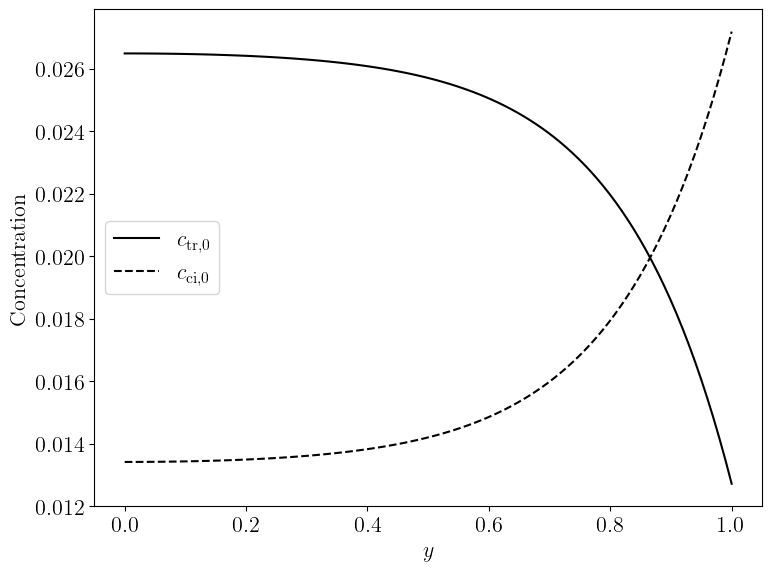

In [13]:
yy = np.linspace(0, 1, 100)

plt.figure(figsize=(8, 6))
plt.plot(yy, c_tr_0(yy), "k-", label=r"$c_{\mathrm{tr}, 0}$")
plt.plot(yy, c_ci_0(yy), "k--", label=r"$c_{\mathrm{ci}, 0}$")
plt.xlabel(r"$y$")
plt.ylabel("Concentration")
plt.legend()
plt.tight_layout()
# plt.savefig("../figures/leading_bulk_concentrations.png", dpi=300)
plt.show()

In [14]:
print("Gamma_tr:", gamma_tr_0)
print("Gamma_ci:", gamma_ci_0)

Gamma_tr: 0.27794141287499124
Gamma_ci: 0.024909520436615665


## First Order

### Forward Problem

#### Solutions for Constants of Integration

In [15]:
# Form linear system for the unknowns
sys = form_equations(omega, f_h)
forcing = sys[:, -1, :]

sys_o = form_equations_o(f_o)[:, :, 0]
forcing_o = sys_o[:, -1]

In [16]:
# Compute unknowns
sols = np.array([np.linalg.solve(sys[:, :-1, i], -forcing[:, i]) for i in range(2 * N)])
sols_o = np.array([np.linalg.solve(sys_o[:, :-1], -forcing_o)])

#### Test Against Analytical Solutions

In [17]:
assert np.allclose(sols[:, 1], -(sols[:, 0] * np.sinh(omega)) / (np.sinh(omega) - omega * np.exp(-omega)))  # Check for B_h

In [18]:
# Constant mode
assert np.allclose(sols_o[0, :3], 0)  # psi_o = 0

#### Solutions

In [19]:
def psi_f(y):
    val_o = psi_o(y)
    val_h = psi_h(omega, y)
    return np.concatenate([
        np.einsum("ij,ji->i", sols_o, val_o[:-1]) + val_o[-1],
        np.einsum("ij,ji->i", sols, val_h[:-1]) + val_h[-1],
    ])

def u_f(y):
    val_o = d_psi_o(y)
    val_h = d_psi_h(omega, y)
    return np.concatenate([
        np.einsum("ij,ji->i", sols_o, val_o[:-1]) + val_o[-1, 0],
        np.einsum("ij,ji->i", sols, val_h[:-1] + val_h[-1]),
    ])

def v_f(y):
    val_h = psi_h(omega, y)
    return np.concatenate([
        [0],
        -1.j * omega * (np.einsum("ij,ji->i", sols, val_h[:-1]) + val_h[-1]),
    ])

def c_f(y):
    val_o = c_o(y)
    val_h = c_h(omega, y)
    return np.concatenate([
        np.einsum("ij,kji->ki", sols_o, val_o[:, :-1]) + val_o[:, -1],
        np.einsum("ij,kji->ki", sols, val_h[:, :-1]) + val_h[:, -1],
    ], axis=1)

def c_tr_f(y):
    return c_f(y)[0]

def c_ci_f(y):
    return c_f(y)[1]

def gamma_tr_f():
    return np.concatenate([
        sols_o[:, -3],
        sols[:, -6],
    ])

def gamma_ci_f():
    return np.concatenate([
        sols_o[:, -2],
        sols[:, -5],
    ])

def S_f():
    return np.concatenate([
        [0],
        sols[:, -3],
    ])

def f_f():
    return np.concatenate([
        sols_o[:, -1],
        sols[:, -4],
    ])

In [20]:
def invert(f, omega):
    def _(x, *args):
        coeffs = f(*args)
        return coeffs[0] + np.sum(coeffs[1:, np.newaxis] * np.exp(1.j * omega[:, np.newaxis] * (x + L)[np.newaxis, :]), axis=0)

    return _

In [21]:
psi = invert(psi_f, omega)
u = invert(u_f, omega)
v = invert(v_f, omega)
c_tr = invert(c_tr_f, omega)
c_ci = invert(c_ci_f, omega)
gamma_tr = invert(gamma_tr_f, omega)
gamma_ci = invert(gamma_ci_f, omega)
S_inv = invert(S_f, omega)
f_inv = invert(f_f, omega)

In [22]:
xx = np.linspace(-L, L, 200)
yy = np.linspace(0, 1, 200)

In [23]:
psii = np.array([psi(xx, y) for y in yy])
uu = np.array([u(xx, y) for y in yy])
vv = np.array([v(xx, y) for y in yy])
cc_tr = np.array([c_tr(xx, y) for y in yy])
cc_ci = np.array([c_ci(xx, y) for y in yy])

ggamma_tr = gamma_tr(xx)
ggamma_ci = gamma_ci(xx)
ttension = -Man * (ggamma_tr + ggamma_ci) * Delta
SS_inv = S_inv(xx)
ff_inv = f_inv(xx)

In [24]:
SS = S_1(xx)
ff = f_1(xx)

### Inverse Problem

#### Solutions for Constants of Integration

In [25]:
# Form linear system for the unknowns
inv_sys = form_inverse_equations(inv_omega, S_h)
inv_forcing = inv_sys[:, -1, :]

In [26]:
# Compute unknowns
inv_sols = np.array([np.linalg.solve(inv_sys[:, :-1, i], -inv_forcing[:, i]) for i in range(2 * last_index)])

#### Test Against Analytical Solutions

#### Solutions

In [27]:
def psi_i(y):
    val_h = psi_h(inv_omega, y)
    return np.concatenate([
        [0],
        np.einsum("ij,ji->i", inv_sols, val_h[:-1]) + val_h[-1],
    ])

def u_i(y):
    val_h = d_psi_h(inv_omega, y)
    return np.concatenate([
        [0],
        np.einsum("ij,ji->i", inv_sols, val_h[:-1] + val_h[-1]),
    ])

def v_i(y):
    val_h = psi_h(inv_omega, y)
    return np.concatenate([
        [0],
        -1.j * inv_omega * (np.einsum("ij,ji->i", inv_sols, val_h[:-1]) + val_h[-1]),
    ])

def c_i(y):
    val_h = c_h(inv_omega, y)
    return np.concatenate([
        np.zeros((2, 1)),
        np.einsum("ij,kji->ki", inv_sols, val_h[:, :-1]) + val_h[:, -1],
    ], axis=1)

def c_tr_i(y):
    return c_i(y)[0]

def c_ci_i(y):
    return c_i(y)[1]

def gamma_tr_i():
    return np.concatenate([
        [0],
        inv_sols[:, -6],
    ])

def gamma_ci_i():
    return np.concatenate([
        [0],
        inv_sols[:, -5],
    ])

def S_i():
    return np.concatenate([
        [0],
        inv_sols[:, -3],
    ])

def f_i():
    return np.concatenate([
        [0],
        inv_sols[:, -4],
    ])

In [28]:
inv_psi = invert(psi_i, inv_omega)
inv_u = invert(u_i, inv_omega)
inv_v = invert(v_i, inv_omega)
inv_c_tr = invert(c_tr_i, inv_omega)
inv_c_ci = invert(c_ci_i, inv_omega)
inv_gamma_tr = invert(gamma_tr_i, inv_omega)
inv_gamma_ci = invert(gamma_ci_i, inv_omega)
inv_S_inv = invert(S_i, inv_omega)
inv_f_inv = invert(f_i, inv_omega)

In [29]:
inv_psii = np.array([inv_psi(xx, y) for y in yy])
inv_uu = np.array([inv_u(xx, y) for y in yy])
inv_vv = np.array([inv_v(xx, y) for y in yy])
inv_cc_tr = np.array([inv_c_tr(xx, y) for y in yy])
inv_cc_ci = np.array([inv_c_ci(xx, y) for y in yy])

inv_ggamma_tr = inv_gamma_tr(xx)
inv_ggamma_ci = inv_gamma_ci(xx)
inv_SS_inv = inv_S_inv(xx)
inv_ff_inv = inv_f_inv(xx)

### Forward Problem Solution plots

#### Interfacial values

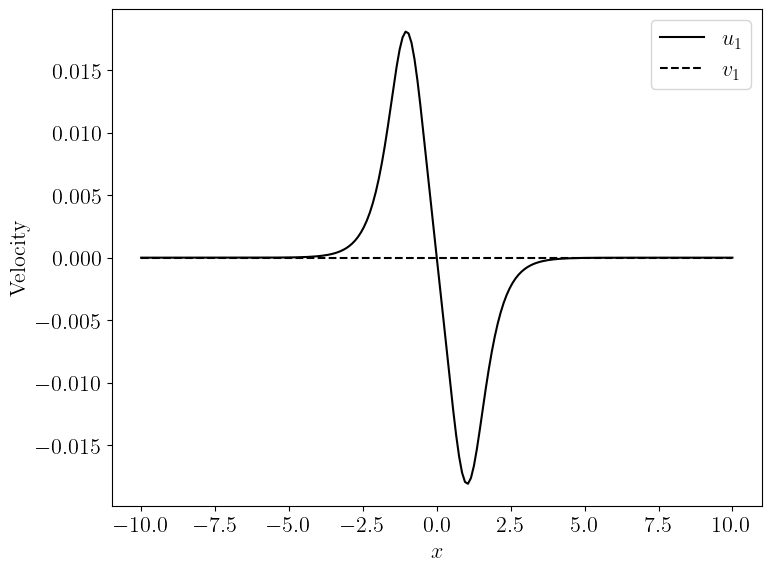

In [30]:
plt.figure(figsize=(8, 6))
plt.plot(xx, uu[-1, :].real, "k-", label=r"$u_1$")
plt.plot(xx, vv[-1, :].real, "k--", label=r"$v_1$")
plt.xlabel(r"$x$")
plt.ylabel("Velocity")
plt.legend()
plt.tight_layout()
# plt.savefig(f"../figures/forward_interfacial_velocity_{label}.png", dpi=300)
plt.show()

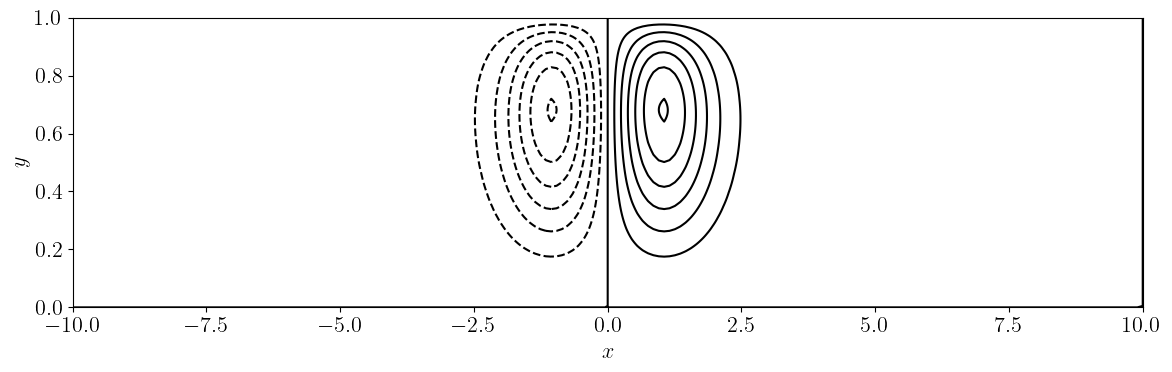

In [31]:
plt.figure(figsize=(12, 4))
plt.contour(xx, yy, psii.real, levels=15, colors="black")
plt.xlabel(r"$x$")
plt.ylabel(r"$y$")
plt.tight_layout()
# plt.savefig(f"../figures/forward_streamlines_{label}.png", dpi=300, bbox_inches="tight")
plt.show()

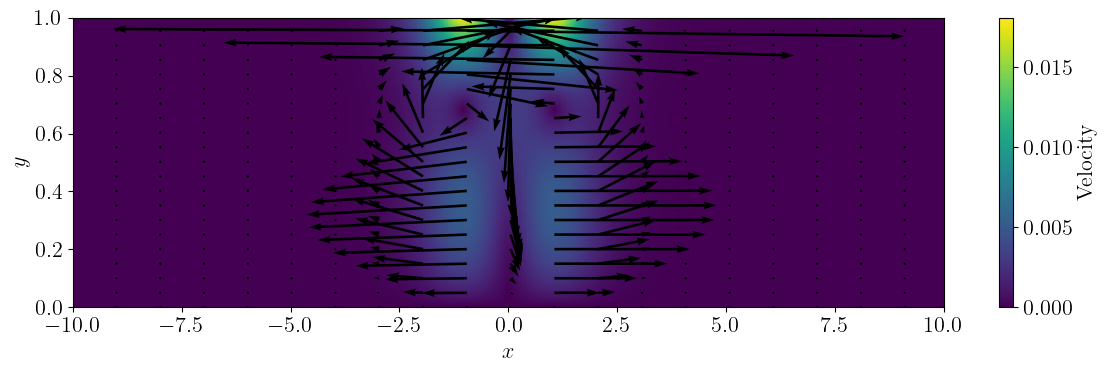

In [32]:
plt.figure(figsize=(12, 4))
plt.quiver(xx[::step], yy[::step], uu[::step, ::step].real, vv[::step, ::step].real)
plt.imshow(np.sqrt(uu[::-1, :].real**2 + vv[::-1, :].real**2), extent=[-L, L, 0, 1], aspect="auto", cmap="viridis")
plt.colorbar(label="Velocity")
plt.xlabel(r"$x$")
plt.ylabel(r"$y$")
plt.tight_layout()
# plt.savefig(f"../figures/forward_velocity_{label}.png", dpi=300, bbox_inches="tight")
plt.show()

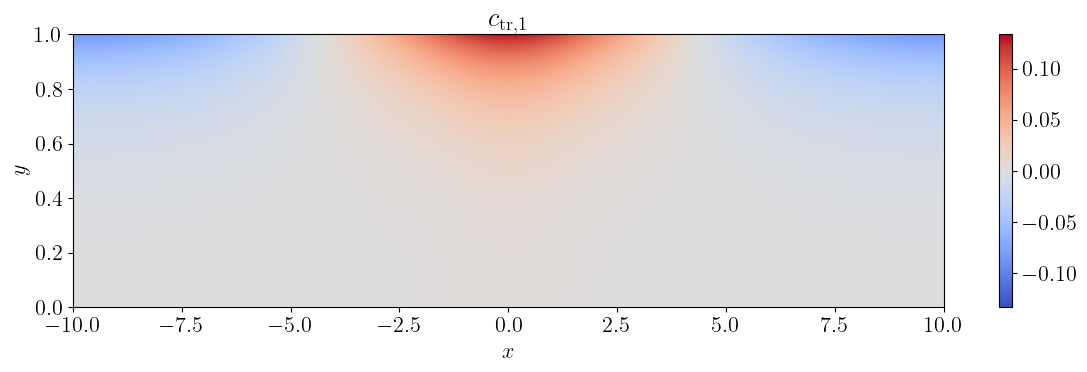

In [33]:
plt.figure(figsize=(12, 4))
plt.imshow(cc_tr[::-1, :].real, extent=[-L, L, 0, 1], aspect="auto", cmap="coolwarm", norm=colors.CenteredNorm())
plt.colorbar()
plt.title(r"$c_{\mathrm{tr}, 1}$")
plt.xlabel(r"$x$")
plt.ylabel(r"$y$")
plt.tight_layout()
# plt.savefig(f"../figures/forward_concentration_tr_{label}.png", dpi=300, bbox_inches="tight")
plt.show()

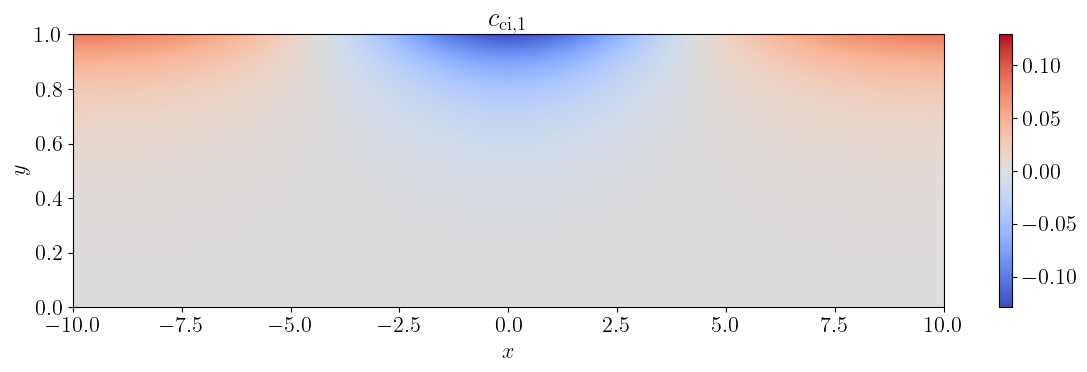

In [34]:
plt.figure(figsize=(12, 4))
plt.imshow(cc_ci[::-1, :].real, extent=[-L, L, 0, 1], aspect="auto", cmap="coolwarm", norm=colors.CenteredNorm())
plt.colorbar()
plt.title(r"$c_{\mathrm{ci}, 1}$")
plt.xlabel(r"$x$")
plt.ylabel(r"$y$")
plt.tight_layout()
# plt.savefig(f"../figures/forward_concentration_ci_{label}.png", dpi=300, bbox_inches="tight")
plt.show()

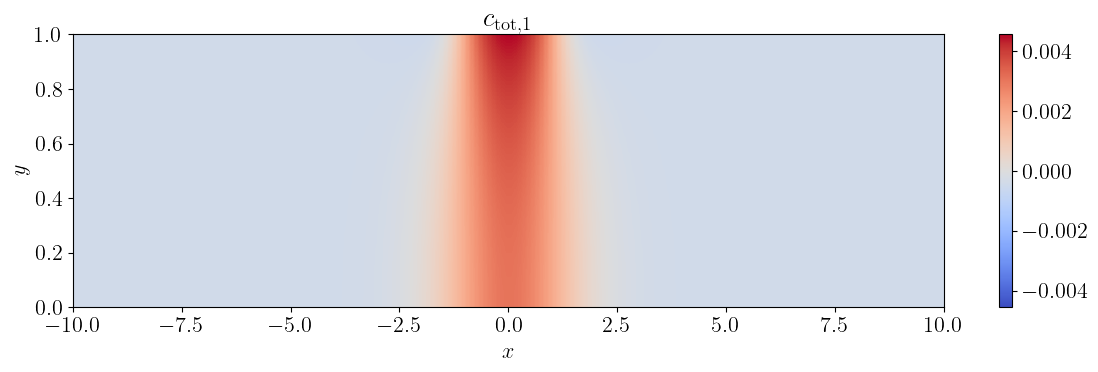

In [35]:
plt.figure(figsize=(12, 4))
plt.imshow(cc_ci[::-1, :].real + cc_tr[::-1, :].real, extent=[-L, L, 0, 1], aspect="auto", cmap="coolwarm", norm=colors.CenteredNorm())
plt.colorbar()
plt.title(r"$c_{\mathrm{tot}, 1}$")
plt.xlabel(r"$x$")
plt.ylabel(r"$y$")
plt.tight_layout()
# plt.savefig(f"../figures/forward_concentration_tot_{label}.png", dpi=300, bbox_inches="tight")
plt.show()

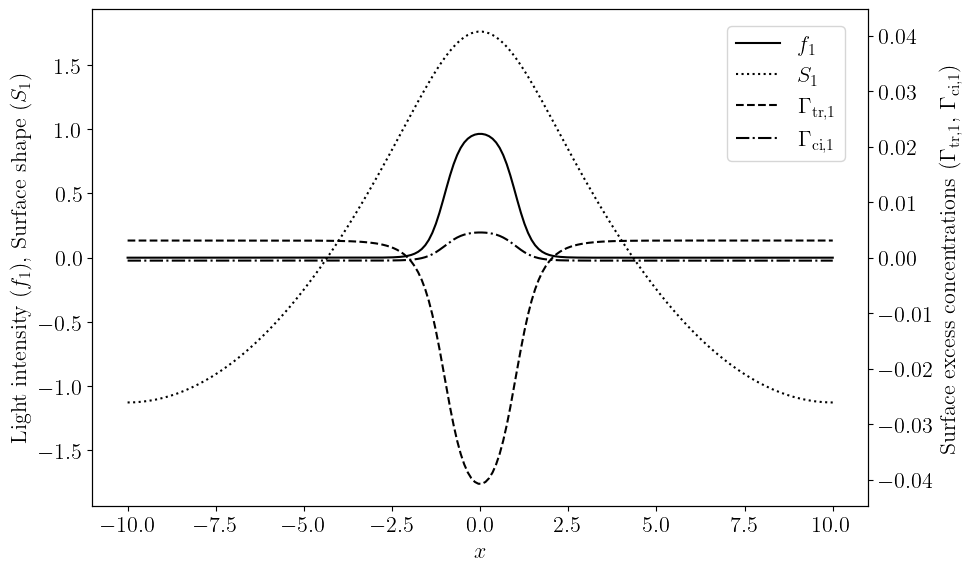

In [36]:
fig, ax1 = plt.subplots(figsize=(10, 6))
ax2 = ax1.twinx()

ax1.plot(xx, ff_inv.real, label=r"$f_1$", color="black")
ax1.plot(xx, SS_inv.real, "k:", label=r"$S_1$")

ax2.plot(xx, ggamma_tr.real, "k--", label=r"$\Gamma_{\mathrm{tr}, 1}$")
ax2.plot(xx, ggamma_ci.real, "k-.", label=r"$\Gamma_{\mathrm{ci}, 1}$")

packing = 1.1
ylim_1 = max(max(abs(ff_inv)), max(abs(SS_inv))) * packing

ax1.set_ylim(-ylim_1, ylim_1)
ax1.set_xlabel(r"$x$")
ax1.set_ylabel(r"Light intensity ($f_1$), Surface shape ($S_1$)")

ylim_2 = max(max(abs(ggamma_tr)), max(abs(ggamma_ci))) * packing

ax2.set_ylim(-ylim_2, ylim_2)
ax2.set_ylabel(r"Surface excess concentrations ($\Gamma_{\mathrm{tr}, 1}$, $\Gamma_{\mathrm{ci}, 1}$)")

fig.legend(loc="upper left", bbox_to_anchor=(0.73,0.95))
fig.tight_layout()

# fig.savefig(f"../figures/forward_interface_{label}.png", dpi=300)
fig.show()

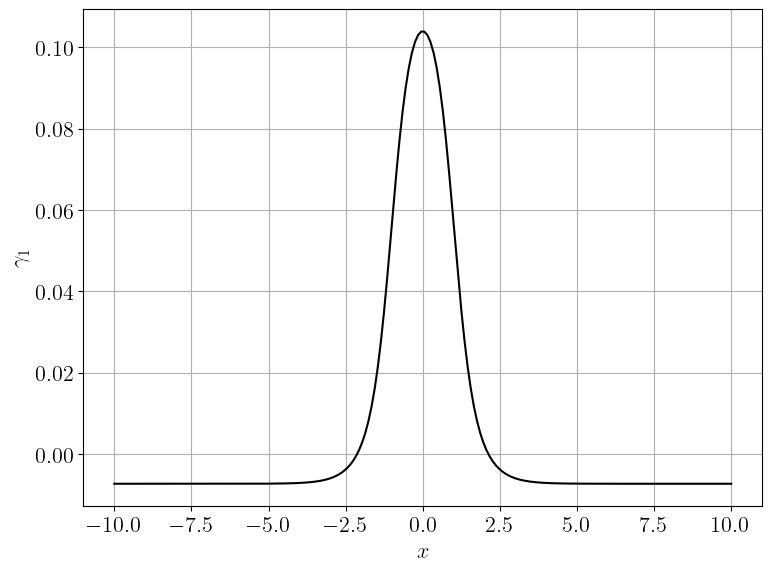

In [37]:
plt.figure(figsize=(8, 6))
plt.plot(xx, ttension.real, "k-")
plt.xlabel(r"$x$")
plt.ylabel(r"$\gamma_1$")
plt.grid()
plt.tight_layout()
# plt.savefig(f"../figures/forward_tension_{label}.png", dpi=300)
plt.show()

### Inverse Problem Solution plots

#### Interfacial values

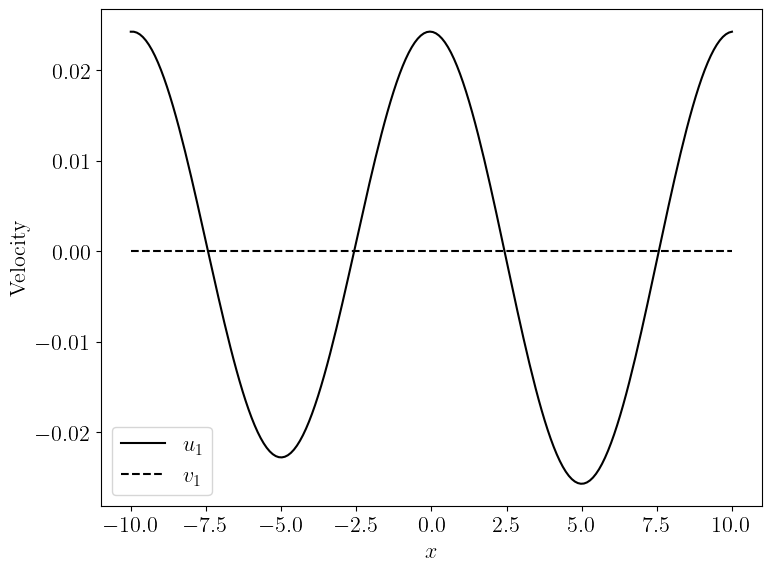

In [38]:
plt.figure(figsize=(8, 6))
plt.plot(xx, inv_uu[-1, :].real, "k-", label=r"$u_1$")
plt.plot(xx, inv_vv[-1, :].real, "k--", label=r"$v_1$")
plt.xlabel(r"$x$")
plt.ylabel("Velocity")
plt.legend()
plt.tight_layout()
# plt.savefig(f"../figures/inverse_interfacial_velocity.png", dpi=300)
plt.show()

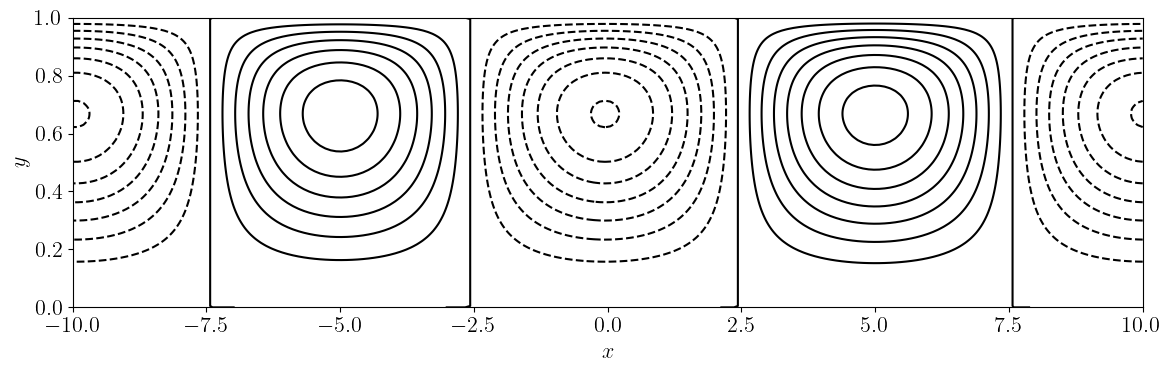

In [39]:
plt.figure(figsize=(12, 4))
plt.contour(xx, yy, inv_psii.real, levels=15, colors="black")
plt.xlabel(r"$x$")
plt.ylabel(r"$y$")
plt.tight_layout()
# plt.savefig(f"../figures/inverse_streamlines.png", dpi=300, bbox_inches="tight")
plt.show()

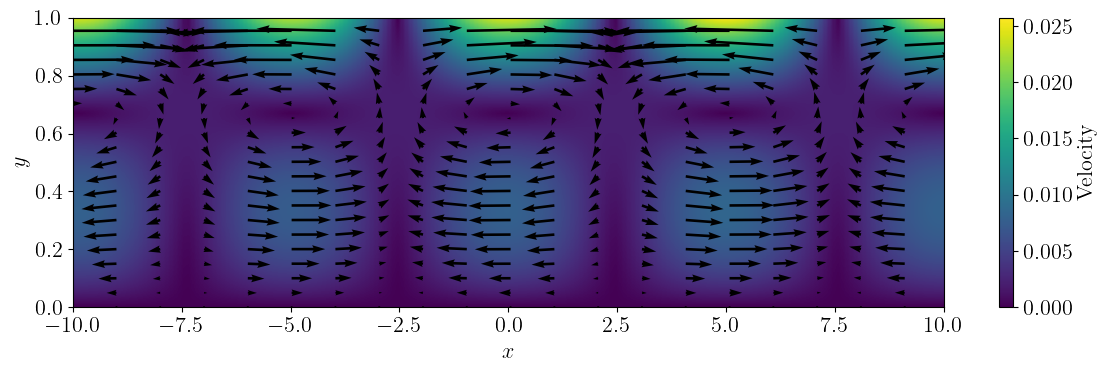

In [40]:
plt.figure(figsize=(12, 4))
plt.quiver(xx[::step], yy[::step], inv_uu[::step, ::step].real, inv_vv[::step, ::step].real)
plt.imshow(np.sqrt(inv_uu[::-1, :].real**2 + inv_vv[::-1, :].real**2), extent=[-L, L, 0, 1], aspect="auto")
plt.colorbar(label="Velocity")
plt.xlabel(r"$x$")
plt.ylabel(r"$y$")
plt.tight_layout()
# plt.savefig(f"../figures/inverse_velocity.png", dpi=300, bbox_inches="tight")
plt.show()

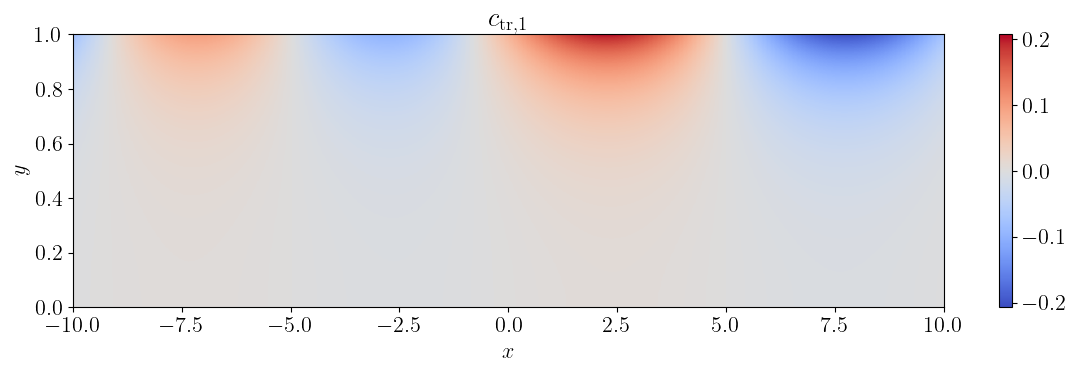

In [41]:
plt.figure(figsize=(12, 4))
plt.imshow(inv_cc_tr[::-1, :].real, extent=[-L, L, 0, 1], aspect="auto", cmap="coolwarm", norm=colors.CenteredNorm())
plt.colorbar()
plt.title(r"$c_{\mathrm{tr}, 1}$")
plt.xlabel(r"$x$")
plt.ylabel(r"$y$")
plt.tight_layout()
# plt.savefig(f"../figures/inverse_concentration_tr.png", dpi=300, bbox_inches="tight")
plt.show()

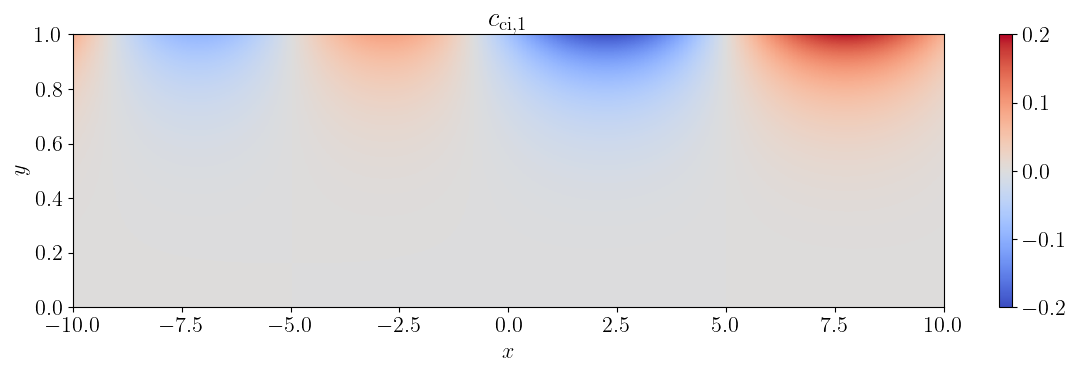

In [42]:
plt.figure(figsize=(12, 4))
plt.imshow(inv_cc_ci[::-1, :].real, extent=[-L, L, 0, 1], aspect="auto", cmap="coolwarm", norm=colors.CenteredNorm())
plt.colorbar()
plt.title(r"$c_{\mathrm{ci}, 1}$")
plt.xlabel(r"$x$")
plt.ylabel(r"$y$")
plt.tight_layout()
# plt.savefig(f"../figures/inverse_concentration_ci.png", dpi=300, bbox_inches="tight")
plt.show()

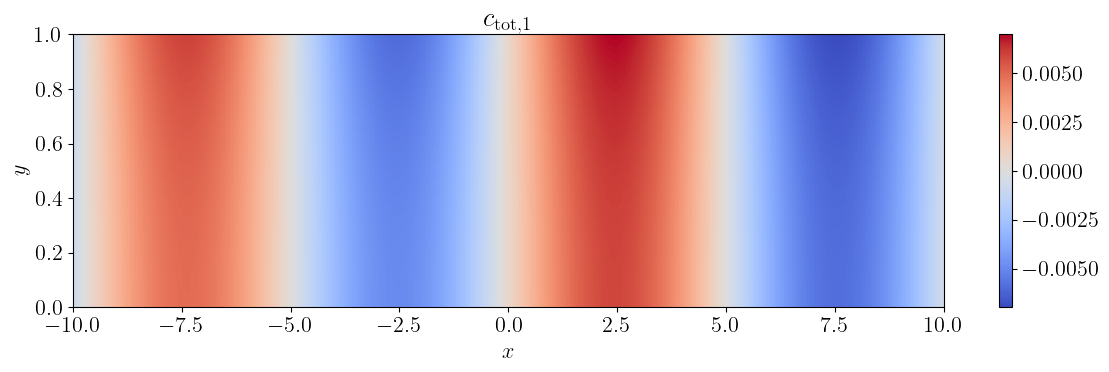

In [43]:
plt.figure(figsize=(12, 4))
plt.imshow(inv_cc_ci[::-1, :].real + inv_cc_tr[::-1, :].real, extent=[-L, L, 0, 1], aspect="auto", cmap="coolwarm", norm=colors.CenteredNorm())
plt.colorbar()
plt.title(r"$c_{\mathrm{tot}, 1}$")
plt.xlabel(r"$x$")
plt.ylabel(r"$y$")
plt.tight_layout()
# plt.savefig(f"../figures/inverse_concentration_tot.png", dpi=300, bbox_inches="tight")
plt.show()

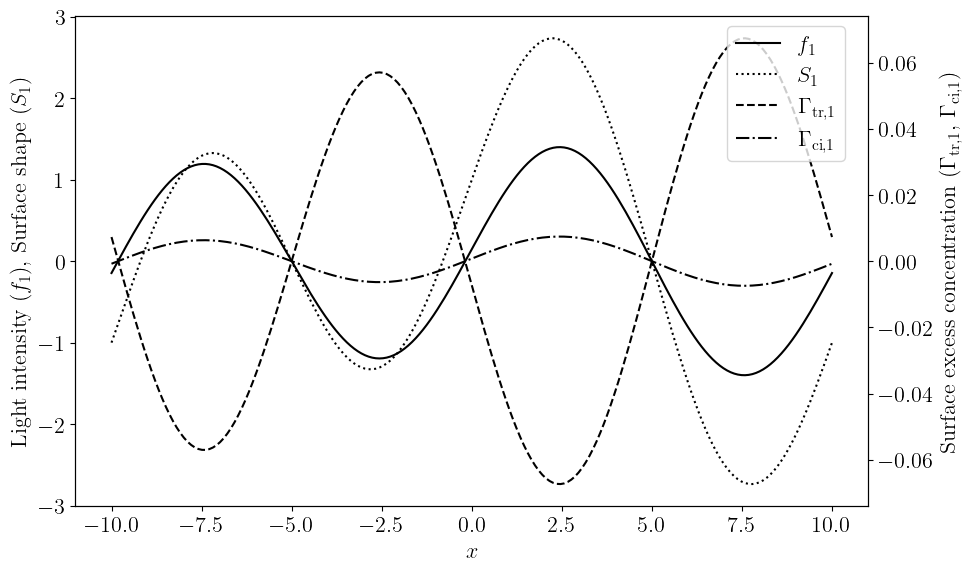

In [45]:
fig, ax1 = plt.subplots(figsize=(10, 6))
ax2 = ax1.twinx()

ax1.plot(xx, inv_ff_inv.real, label=r"$f_1$", color="black")
ax1.plot(xx, inv_SS_inv.real, "k:", label=r"$S_1$")

ax2.plot(xx, inv_ggamma_tr.real, "k--", label=r"$\Gamma_{\mathrm{tr}, 1}$")
ax2.plot(xx, inv_ggamma_ci.real, "k-.", label=r"$\Gamma_{\mathrm{ci}, 1}$")

packing = 1.1
ylim_1 = max(max(abs(inv_ff_inv)), max(abs(inv_SS_inv))) * packing

ax1.set_ylim(-ylim_1, ylim_1)
ax1.set_xlabel(r"$x$")
ax1.set_ylabel(r"Light intensity ($f_1$), Surface shape ($S_1$)")

ylim_2 = max(max(abs(inv_ggamma_tr)), max(abs(inv_ggamma_ci))) * packing

ax2.set_ylim(-ylim_2, ylim_2)
ax2.set_ylabel(r"Surface excess concentration ($\Gamma_{\mathrm{tr}, 1}$, $\Gamma_{\mathrm{ci}, 1}$)")

fig.legend(loc="upper left", bbox_to_anchor=(0.73,0.95))
fig.tight_layout()

# fig.savefig(f"../figures/inverse_interface.png", dpi=300)
fig.show()

### General Solution

In [21]:
S_modes = np.concatenate([S_f()[1:N + 1], S_f()[:1],  S_f()[N + 1:]])

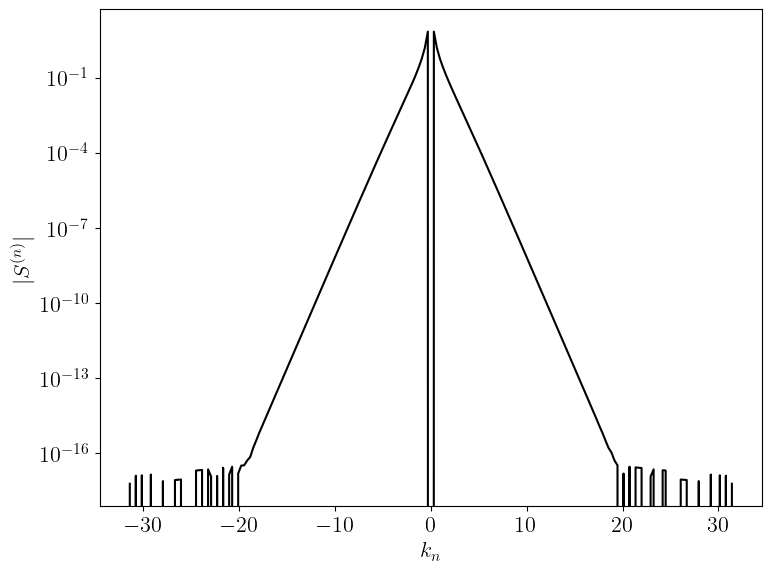

In [23]:
plt.figure(figsize=(8, 6))
plt.plot(omega_full, np.abs(S_modes), "k-")
plt.yscale("log")
plt.xlabel(r"$k_n$")
plt.ylabel(r"$|S^{(n)}|$")
plt.tight_layout()
# plt.savefig(f"../figures/general_interface.png", dpi=300)
plt.show()